In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

from nilearn.image import mean_img, get_data 
from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting, image
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix, plot_roi, plot_epi
from matplotlib.patches import Rectangle

#import nilearn.image as image

%matplotlib inline

In [2]:
# Fetching dataset
haxby_ds = datasets.fetch_haxby(fetch_stimuli=True)

In [3]:
haxby_ds.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [4]:
# Read the data documentation
print(haxby_ds['description'].decode('utf-8'))

Haxby 2001 results


Notes
-----
Results from a classical fMRI study that investigated the differences between
the neural correlates of face versus object processing in the ventral visual
stream. Face and object stimuli showed widely distributed and overlapping
response patterns.

Content
-------
The "simple" dataset includes
    :'func': Nifti images with bold data
    :'session_target': Text file containing session data
    :'mask': Nifti images with employed mask
    :'session': Text file with condition labels


The full dataset additionally includes
    :'anat': Nifti images with anatomical image
    :'func': Nifti images with bold data
    :'mask_vt': Nifti images with mask for ventral visual/temporal cortex
    :'mask_face': Nifti images with face-reponsive brain regions
    :'mask_house': Nifti images with house-reponsive brain regions
    :'mask_face_little': Spatially more constrained version of the above
    :'mask_house_little': Spatially more constrained version of the abov

## Plotting the used stimuli Haxby dataset

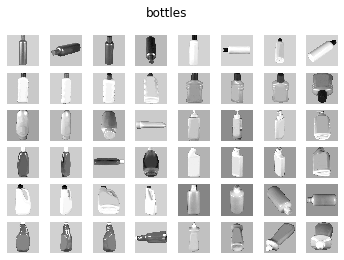

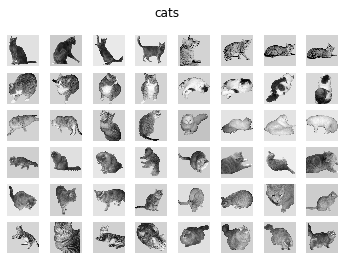

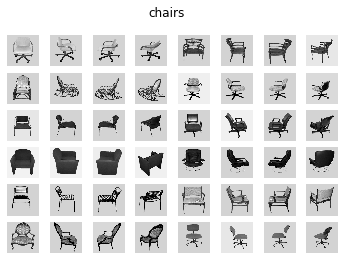

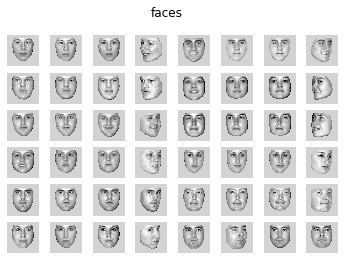

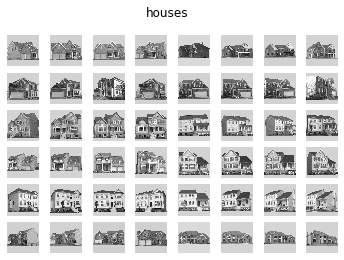

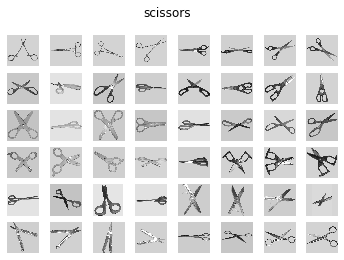

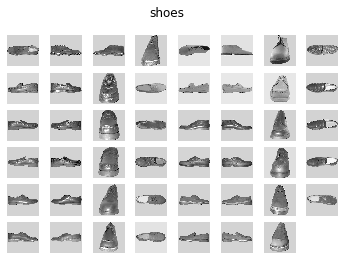

In [5]:
stimulus_info = haxby_ds.stimuli

for stim_type in stimulus_info:
    # skip control images, there are too many
    if stim_type != 'controls':

        file_names = stimulus_info[stim_type]

        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stim_type)

        for img_path, ax in zip(file_names, axes.ravel()):
            ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

        for ax in axes.ravel():
            ax.axis("off")

## Visualizing the fMRI volume

In [6]:
mask_house_file = haxby_ds.mask_house[0]
mask_face_file = haxby_ds.mask_face[0]
mask_vt_file = haxby_ds.mask_vt[0]
func_file = haxby_ds.func[0]
anat_file = haxby_ds.anat[0]

mean_img = image.mean_img(func_file)

**Plotting the functional image:**

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



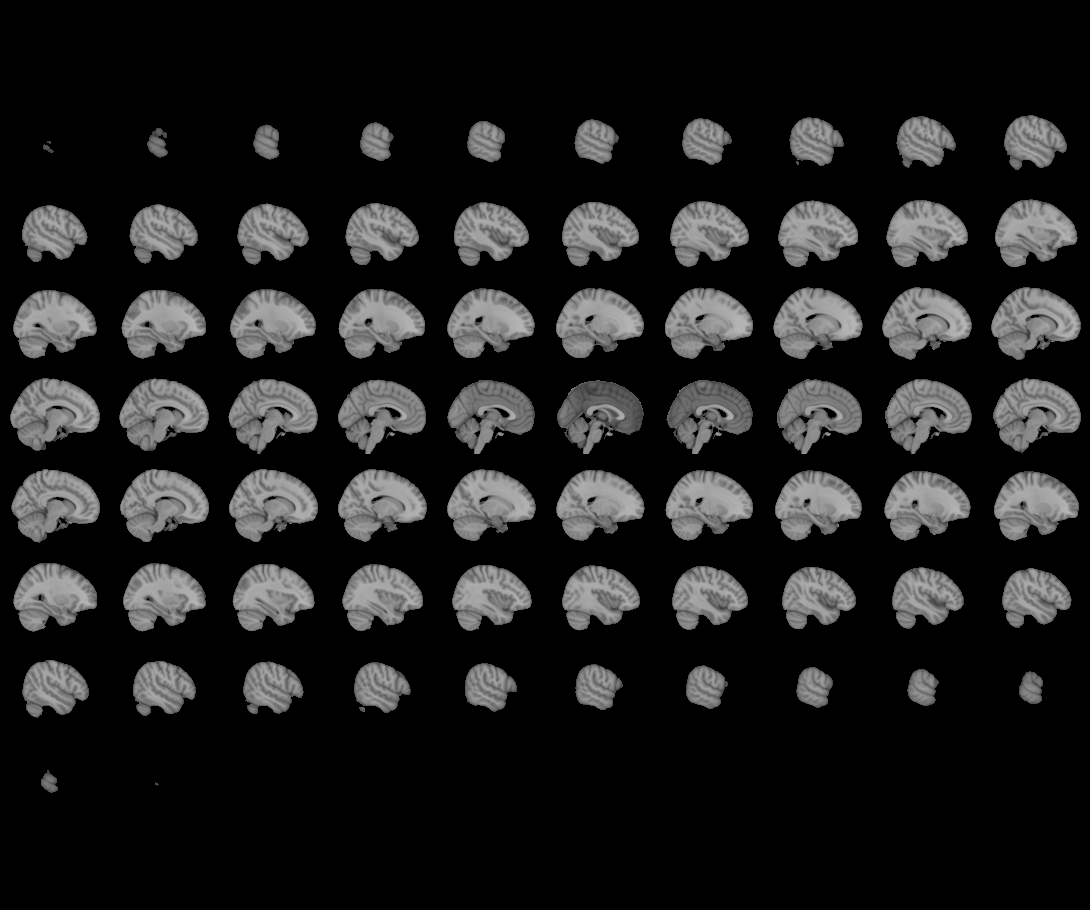
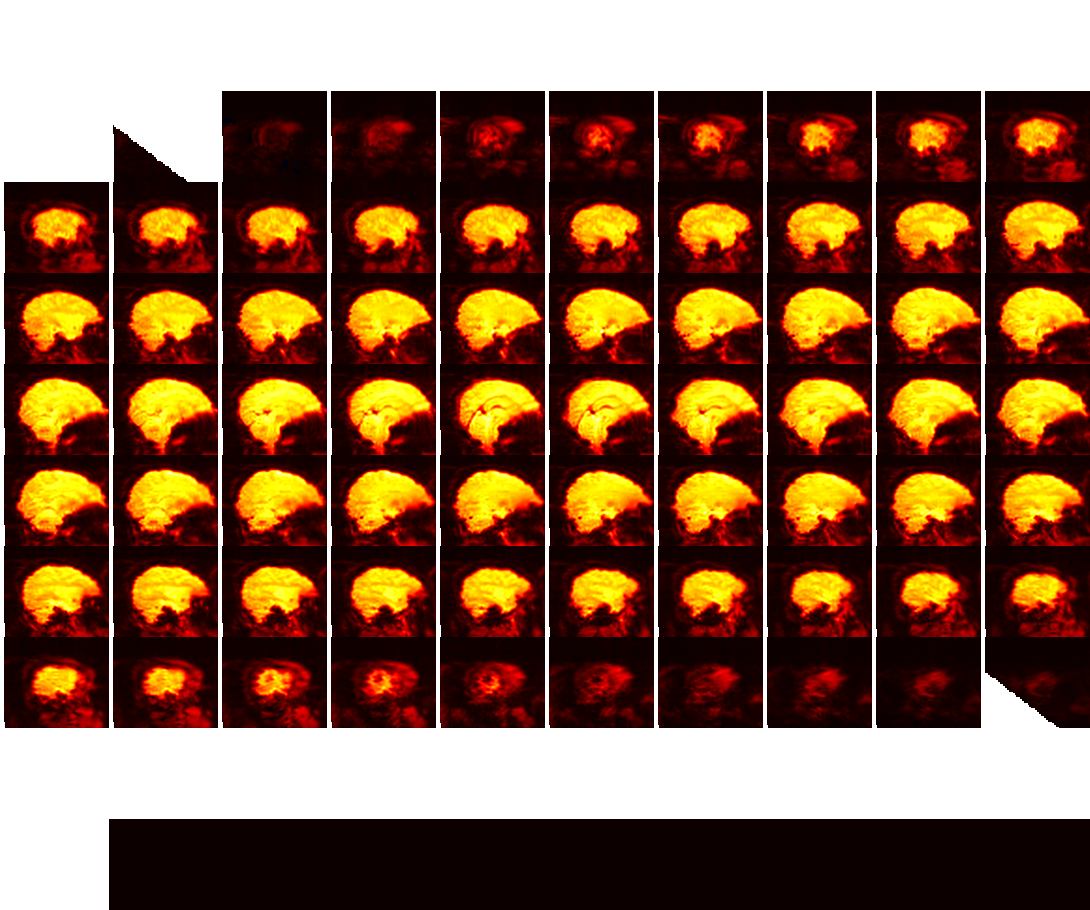

In [7]:
# Load the functional image
img = nib.load(haxby_ds['func'][0])

# Take a look at the first time point
plotting.view_img(image.index_img(img, 2))

**Plotting the mean_image:**

In [8]:
# Plotting the mean_image
plotting.view_img(mean_img(func_file), threshold=None)

TypeError: 'Nifti1Image' object is not callable

**Plotting the ROI:**

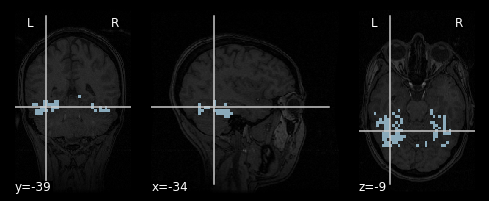

In [9]:
# Feature extraction from fMRI volumes to a data matrix (background is anatomical scan)

mask_vt_file = haxby_ds.mask_vt[0]

plotting.plot_roi(mask_vt_file, bg_img=anat_file, cmap='Paired', black_bg='true', alpha=0.8)

**Plotting the masks:**

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: The following kwargs were not used by contour: 'contours'
  **kwargs)


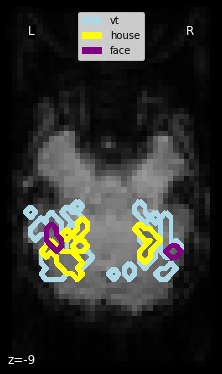

In [10]:
z_slice = -9

fig = plt.figure(figsize=(4, 5), facecolor='k' )

display = plot_anat(mean_img, display_mode='z', cut_coords=[z_slice], figure=fig)

display.add_contours(mask_vt_file, contours=0.7, antialiased=False, linewidths=4., levels=[0], colors=['lightblue'])
display.add_contours(mask_house_file, contours=0.7, antialiased=False, linewidths=4., levels=[0], colors=['yellow'])
display.add_contours(mask_face_file, contours=0.7, antialiased=False, linewidths=4., levels=[0], colors=['purple'])

p_v = Rectangle((0, 0), 1, 1, fc="lightblue")
p_h = Rectangle((0, 0), 1, 1, fc="yellow")
p_f = Rectangle((0, 0), 1, 1, fc="purple")
plt.legend([p_v, p_h, p_f], ["vt", "house", "face"], loc='upper center' )

**NiftiMasker:**

First functional nifti image (4D) is located at: /home/srastegarnia/nilearn_data/haxby2001/subj2/bold.nii.gz


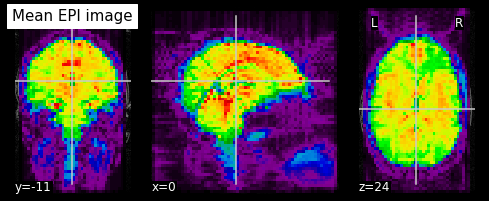

In [11]:
# func_file = haxby_ds.func[0]
#miyawaki_filename = miyawaki_dataset.func[0]

# print basic information on the dataset
print('First functional nifti image (4D) is located at: %s' % haxby_ds.func[0])  # 4D data

mean_img = image.mean_img(func_file)
#miyawaki_mean_img = image.mean_img(miyawaki_filename)

plot_epi(mean_img, title='Mean EPI image', bg_img=anat_file)

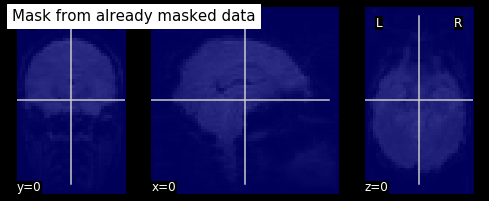

In [12]:
masker = NiftiMasker()
masker.fit(func_file)

# Plot the generated mask using the mask_img_ attribute
plot_roi(masker.mask_img_, mean_img, title="Mask from already masked data")

In [13]:
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


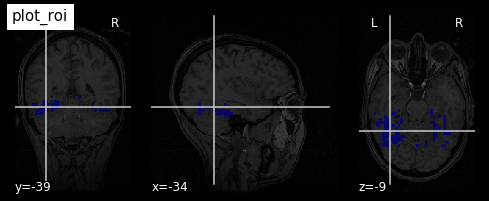

In [14]:
plotting.plot_roi(mask_vt_file, bg_img=anat_file, title="plot_roi")

In [15]:
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)
fmri_masked = masker.fit_transform(func_file)

# Report depict the computed mask
masker.generate_report()

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,/home/srastegarnia/nilearn_data/haxby2001/subj2/mask4_vt.nii.gz
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True
